##Fit a prf model with frequency selectivity and an output nonlinearity.
July.2015 high-resolution CMRR data for the "match_nonmatch" project.

Project notes: https://drive.google.com/open?id=1m1rmotkmtgwY99Q_k71YDorUPq_DkCSJ0LselY13_v4

In [1]:
%pylab inline
import hrf_fitting.src.preprocessing as preproc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage

from PIL import Image
from hrf_fitting.src.features import construct_kernel_set
from scipy.signal import convolve2d
from os import path
from sklearn import linear_model

Populating the interactive namespace from numpy and matplotlib


###Select data

select a subject and corresponding database

In [2]:
subject = 's1055'
db =  '/media/tnaselar/Data/July_2015_preproc/'+subject+'/PS/aligned_db.csv'

import into pandas dataframe and view it

In [3]:
data_db = pd.io.parsers.read_csv(db,header=0)
data_db.tail(20)

,runID,date,subject,experiment,working_vol,brain_mask,sessionID,runType,design matrix,frame_file,...,vox_x,vox_y,vox_z,run_code_path,run_code_file,design_matrix_path,frameFilePath,picPath,siemensRef,padVol
17,17,29/07/2015,s1055,match_nonmatch,/media/tnaselar/Data/July_2015_preproc/s1055/P...,/media/tnaselar/Data/July_2015_preproc/s1055/P...,1,wedge,none,wedge_frame_file.txt,...,0.8,0.8,0.8,/musc.repo/mri/7T.cmrr/July.2015/PS/presentation,run_experiment.py,none,/musc.repo/mri/7T.cmrr/July.2015/PS/presentati...,/musc.repo/mri/7T.cmrr/July.2015/PS/presentati...,0,0
18,18,29/07/2015,s1055,match_nonmatch,/media/tnaselar/Data/July_2015_preproc/s1055/P...,/media/tnaselar/Data/July_2015_preproc/s1055/P...,1,bar,none,bar_frame_file.txt,...,0.8,0.8,0.8,/musc.repo/mri/7T.cmrr/July.2015/PS/presentation,run_experiment.py,none,/musc.repo/mri/7T.cmrr/July.2015/PS/presentati...,/musc.repo/mri/7T.cmrr/July.2015/PS/presentati...,0,0
19,19,04/08/2015,s1055,match_nonmatch,/media/tnaselar/Data/July_2015_preproc/s1055/P...,/media/tnaselar/Data/July_2015_preproc/s1055/P...,1,freq,none,spatial_freq_run_002.txt,...,0.8,0.8,0.8,/musc.repo/mri/7T.cmrr/July.2015/PS/presentation,run_experiment.py,none,/musc.repo/mri/7T.cmrr/July.2015/PS/presentati...,/musc.repo/mri/7T.cmrr/July.2015/PS/presentati...,0,0
20,20,04/08/2015,s1055,match_nonmatch,/media/tnaselar/Data/July_2015_preproc/s1055/P...,/media/tnaselar/Data/July_2015_preproc/s1055/P...,1,wedge,none,wedge_frame_file.txt,...,0.8,0.8,0.8,/musc.repo/mri/7T.cmrr/July.2015/PS/presentation,run_experiment.py,none,/musc.repo/mri/7T.cmrr/July.2015/PS/presentati...,/musc.repo/mri/7T.cmrr/July.2015/PS/presentati...,0,0
21,21,04/08/2015,s1055,match_nonmatch,/media/tnaselar/Data/July_2015_preproc/s1055/P...,/media/tnaselar/Data/July_2015_preproc/s1055/P...,1,wedge,none,wedge_frame_file.txt,...,0.8,0.8,0.8,/musc.repo/mri/7T.cmrr/July.2015/PS/presentation,run_experiment.py,none,/musc.repo/mri/7T.cmrr/July.2015/PS/presentati...,/musc.repo/mri/7T.cmrr/July.2015/PS/presentati...,0,0
22,22,04/08/2015,s1055,match_nonmatch,/media/tnaselar/Data/July_2015_preproc/s1055/P...,/media/tnaselar/Data/July_2015_preproc/s1055/P...,1,bar,none,bar_frame_file.txt,...,0.8,0.8,0.8,/musc.repo/mri/7T.cmrr/July.2015/PS/presentation,run_experiment.py,none,/musc.repo/mri/7T.cmrr/July.2015/PS/presentati...,/musc.repo/mri/7T.cmrr/July.2015/PS/presentati...,0,0
23,23,04/08/2015,s1055,match_nonmatch,/media/tnaselar/Data/July_2015_preproc/s1055/P...,/media/tnaselar/Data/July_2015_preproc/s1055/P...,1,bar,none,bar_frame_file.txt,...,0.8,0.8,0.8,/musc.repo/mri/7T.cmrr/July.2015/PS/presentation,run_experiment.py,none,/musc.repo/mri/7T.cmrr/July.2015/PS/presentati...,/musc.repo/mri/7T.cmrr/July.2015/PS/presentati...,0,0
24,24,04/08/2015,s1055,match_nonmatch,/media/tnaselar/Data/July_2015_preproc/s1055/P...,/media/tnaselar/Data/July_2015_preproc/s1055/P...,1,art,none,mia_art_run_00.txt,...,0.8,0.8,0.8,/musc.repo/mri/7T.cmrr/July.2015/PS/presentation,run_experiment.py,none,/musc.repo/mri/7T.cmrr/July.2015/PS/presentati...,/musc.repo/mri/7T.cmrr/July.2015/PS/presentati...,0,0
25,25,04/08/2015,s1055,match_nonmatch,/media/tnaselar/Data/July_2015_preproc/s1055/P...,/media/tnaselar/Data/July_2015_preproc/s1055/P...,1,art,none,mia_art_run_01.txt,...,0.8,0.8,0.8,/musc.repo/mri/7T.cmrr/July.2015/PS/presentation,run_experiment.py,none,/musc.repo/mri/7T.cmrr/July.2015/PS/presentati...,/musc.repo/mri/7T.cmrr/July.2015/PS/presentati...,0,0
26,26,04/08/2015,s1055,match_nonmatch,/media/tnaselar/Data/July_2015_preproc/s1055/P...,/media/tnaselar/Data/July_2015_preproc/s1055/P...,1,art,none,mia_art_run_03.txt,...,0.8,0.8,0.8,/musc.repo/mri/7T.cmrr/July.2015/PS/presentation,run_experiment.py,none,/musc.repo/mri/7T.cmrr/July.2015/PS/presentati...,/musc.repo/mri/7T.cmrr/July.2015/PS/presentati...,0,0


###Specify runs for training and testing the model

In [4]:
def select_run(row,runType):
    return row['runType'] in [runType]


wedge_runs = list(data_db[data_db.apply(select_run,axis=1,args=('wedge',))].runID)
bar_runs = list(data_db[data_db.apply(select_run,axis=1,args=('bar',))].runID)
art_runs = list(data_db[data_db.apply(select_run,axis=1,args=('art',))].runID)

training_runs = wedge_runs[1:3]+bar_runs[1:3]
selection_runs = wedge_runs[0:1]+bar_runs[0:1]
validation_runs = wedge_runs[3:4]+bar_runs[3:4]
# validation_run_ids = data_db[data_db.apply(lambda row: row['runType'] in validation_run_types,axis=1)].runID

In [5]:
data_db.iloc[training_runs] 

,runID,date,subject,experiment,working_vol,brain_mask,sessionID,runType,design matrix,frame_file,...,vox_x,vox_y,vox_z,run_code_path,run_code_file,design_matrix_path,frameFilePath,picPath,siemensRef,padVol
1,1,27/07/2015,s1055,match_nonmatch,/media/tnaselar/Data/July_2015_preproc/s1055/P...,/media/tnaselar/Data/July_2015_preproc/s1055/P...,1,wedge,none,wedge_frame_file.txt,...,0.8,0.8,0.8,/musc.repo/mri/7T.cmrr/July.2015/PS/presentation,run_experiment.py,none,/musc.repo/mri/7T.cmrr/July.2015/PS/presentati...,/musc.repo/mri/7T.cmrr/July.2015/PS/presentati...,0,0
13,13,27/07/2015,s1055,match_nonmatch,/media/tnaselar/Data/July_2015_preproc/s1055/P...,/media/tnaselar/Data/July_2015_preproc/s1055/P...,1,wedge,none,wedge_frame_file.txt,...,0.8,0.8,0.8,/musc.repo/mri/7T.cmrr/July.2015/PS/presentation,run_experiment.py,none,/musc.repo/mri/7T.cmrr/July.2015/PS/presentati...,/musc.repo/mri/7T.cmrr/July.2015/PS/presentati...,0,0
3,3,27/07/2015,s1055,match_nonmatch,/media/tnaselar/Data/July_2015_preproc/s1055/P...,/media/tnaselar/Data/July_2015_preproc/s1055/P...,1,bar,none,bar_frame_file.txt,...,0.8,0.8,0.8,/musc.repo/mri/7T.cmrr/July.2015/PS/presentation,run_experiment.py,none,/musc.repo/mri/7T.cmrr/July.2015/PS/presentati...,/musc.repo/mri/7T.cmrr/July.2015/PS/presentati...,0,0
4,4,27/07/2015,s1055,match_nonmatch,/media/tnaselar/Data/July_2015_preproc/s1055/P...,/media/tnaselar/Data/July_2015_preproc/s1055/P...,1,bar,none,bar_frame_file.txt,...,0.8,0.8,0.8,/musc.repo/mri/7T.cmrr/July.2015/PS/presentation,run_experiment.py,none,/musc.repo/mri/7T.cmrr/July.2015/PS/presentati...,/musc.repo/mri/7T.cmrr/July.2015/PS/presentati...,0,0


In [6]:
data_db.iloc[selection_runs]

,runID,date,subject,experiment,working_vol,brain_mask,sessionID,runType,design matrix,frame_file,...,vox_x,vox_y,vox_z,run_code_path,run_code_file,design_matrix_path,frameFilePath,picPath,siemensRef,padVol
0,0,27/07/2015,s1055,match_nonmatch,/media/tnaselar/Data/July_2015_preproc/s1055/P...,/media/tnaselar/Data/July_2015_preproc/s1055/P...,1,wedge,none,wedge_frame_file.txt,...,0.8,0.8,0.8,/musc.repo/mri/7T.cmrr/July.2015/PS/presentation,run_experiment.py,none,/musc.repo/mri/7T.cmrr/July.2015/PS/presentati...,/musc.repo/mri/7T.cmrr/July.2015/PS/presentati...,0,0
2,2,27/07/2015,s1055,match_nonmatch,/media/tnaselar/Data/July_2015_preproc/s1055/P...,/media/tnaselar/Data/July_2015_preproc/s1055/P...,1,bar,none,bar_frame_file.txt,...,0.8,0.8,0.8,/musc.repo/mri/7T.cmrr/July.2015/PS/presentation,run_experiment.py,none,/musc.repo/mri/7T.cmrr/July.2015/PS/presentati...,/musc.repo/mri/7T.cmrr/July.2015/PS/presentati...,0,0


In [7]:
data_db.iloc[validation_runs]

,runID,date,subject,experiment,working_vol,brain_mask,sessionID,runType,design matrix,frame_file,...,vox_x,vox_y,vox_z,run_code_path,run_code_file,design_matrix_path,frameFilePath,picPath,siemensRef,padVol
17,17,29/07/2015,s1055,match_nonmatch,/media/tnaselar/Data/July_2015_preproc/s1055/P...,/media/tnaselar/Data/July_2015_preproc/s1055/P...,1,wedge,none,wedge_frame_file.txt,...,0.8,0.8,0.8,/musc.repo/mri/7T.cmrr/July.2015/PS/presentation,run_experiment.py,none,/musc.repo/mri/7T.cmrr/July.2015/PS/presentati...,/musc.repo/mri/7T.cmrr/July.2015/PS/presentati...,0,0
14,14,27/07/2015,s1055,match_nonmatch,/media/tnaselar/Data/July_2015_preproc/s1055/P...,/media/tnaselar/Data/July_2015_preproc/s1055/P...,1,bar,none,bar_frame_file.txt,...,0.8,0.8,0.8,/musc.repo/mri/7T.cmrr/July.2015/PS/presentation,run_experiment.py,none,/musc.repo/mri/7T.cmrr/July.2015/PS/presentati...,/musc.repo/mri/7T.cmrr/July.2015/PS/presentati...,0,0


###Load neural data

In [8]:
training_vols = preproc.load_runs(data_db,training_runs)
selection_vols = preproc.load_runs(data_db,selection_runs)
# validation_vols = preproc.load_runs(data_db,validation_runs)

detrending run 0 with window_length: 101
detrending run 1 with window_length: 101
detrending run 2 with window_length: 101
detrending run 3 with window_length: 101
zscoring 0 thru 200
zscoring 200 thru 400
zscoring 400 thru 600
zscoring 600 thru 800
detrending run 0 with window_length: 101
detrending run 1 with window_length: 101
zscoring 0 thru 200
zscoring 200 thru 400


###Load images
We happen to know that for the 'wedge' and 'bar' runs, the framefiles are identical. So we don't need
to all of them into memory. Instead, we load in one copy, and create a function that will be used to concatenate feature matrices when it's time to train the model.

In [9]:
##some important units
image_downsampling = .5 ##I choose this
pixel_per_deg = 34.751*image_downsampling    ##I just know this  
pixels_per_stimulus = int(768*image_downsampling) ##I just know this
wedge_nvols = data_db.iloc[selection_runs[0]].nvols ##we happen to know what 0 and 1 mean
bar_nvols = data_db.iloc[selection_runs[1]].nvols

In [10]:
wedge_stim_list = preproc.load_frame_file(data_db.iloc[selection_runs[0]]) 
bar_stim_list = preproc.load_frame_file(data_db.iloc[selection_runs[1]])
pic_path = data_db.iloc[selection_runs[0]].picPath

In [11]:
x = map(lambda f: path.join(pic_path,f),wedge_stim_list)
y = lambda img: np.array(Image.open(img).convert('L').resize((pixels_per_stimulus,)*2))

wedge_imgs = np.array(map(y,x), ndmin=3)
print 'wedge images taking up %0.3f GB of RAM' %(wedge_imgs.nbytes/1024./1024./1024.)

wedge images taking up 0.618 GB of RAM


In [12]:
bar_imgs = np.array(map(lambda img: np.array(Image.open(img).convert('L').resize((pixels_per_stimulus,)*2)),
                          map(lambda f: path.join(pic_path,f),bar_stim_list)),
                    ndmin=3)
print 'bar images taking up %0.3f GB of RAM' %(bar_imgs.nbytes/1024./1024./1024.)

bar images taking up 0.618 GB of RAM


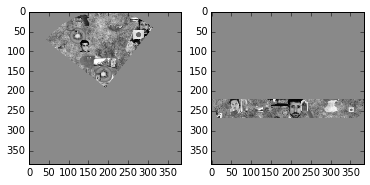

In [13]:
plt.figure
plt.subplot(1,2,1)
plt.imshow(wedge_imgs[500,:,:],cmap=cm.gray)
plt.subplot(1,2,2)
plt.imshow(bar_imgs[500,:,:],cmap=cm.gray)

###Construct features

Specify the set of ripple filters

In [15]:

##preferences
min_cyc_deg = 0.010008
max_cyc_deg = 2.900006
min_kernel_size = 1.    ##deg
max_kernel_size = 6.    ##deg
num_freq_levels = 8
num_size_levels = 8
kernel_spacing = 1
boundary_condition = 1

##---frequencies
##cyc/deg
freq_df = pd.DataFrame(np.logspace(np.log10(min_cyc_deg),np.log10(max_cyc_deg),num=num_freq_levels,endpoint=True),
                       columns=['cyc/deg'])
##cyc/pix
freq_df['cyc/pix'] = freq_df['cyc/deg'].apply(lambda x: x/pixel_per_deg)
##cyc/image
freq_df['cyc/image'] = freq_df['cyc/pix'].apply(lambda x: x*pixels_per_stimulus)
##pix/cyc -- check to make sure greater than 6, as per Curtis Baker
freq_df['pix/cyc'] = freq_df['cyc/pix'].apply(lambda x: 1/x)

##---kernel sizes
##deg
size_df = pd.DataFrame(np.linspace(min_kernel_size, max_kernel_size,num=num_size_levels,endpoint=True),
                       columns = ['deg.'])
##pix
size_df['pix'] = size_df['deg.'].apply(lambda x: x*pixel_per_deg)


Spatial frequencies in various units

In [16]:
freq_df

,cyc/deg,cyc/pix,cyc/image,pix/cyc
0,0.010008,0.000576,0.221178,1736.161071
1,0.022494,0.001295,0.497122,772.446406
2,0.050558,0.002910,1.117338,343.674018
3,0.113635,0.006540,2.511344,152.906181
4,0.255408,0.014699,5.644531,68.030457
5,0.574058,0.033038,12.686724,30.267861
6,1.290260,0.074257,28.514854,13.466665
7,2.900006,0.166902,64.090375,5.991539


Kernel sizes in various units

In [17]:
size_df

,deg.,pix
0,1.000000,17.375500
1,1.714286,29.786571
2,2.428571,42.197643
3,3.142857,54.608714
4,3.857143,67.019786
5,4.571429,79.430857
6,5.285714,91.841929
7,6.000000,104.253000


###Fit the ripple model
Leave-one-out validation, at least 10 times, making sure each run type gets left out a (roughly) equal number of times.

Loop over size/frequency/postions, training/testing at each.

In [18]:
hrf_length = 12 ##20 s should do it.
alpha = 1 ## I dunno.

In [19]:
model_grid = pd.DataFrame(index = size_df['pix'],columns=freq_df['cyc/image'])

In [ ]:
model_grid = pd.DataFrame(index = size_df['pix'],columns=freq_df['cyc/image'])

for kernel_size in model_grid.index:
    for freq in model_grid.columns:
        ##construct filters
        filters = construct_kernel_set(freq,kernel_size,
                                       pixels_per_stimulus,kernel_spacing,boundary_condition=boundary_condition)
        num_filters = filters.shape[0]
        print '===========================model (%0.2f, %0.2f) with %d postions' %(kernel_size,freq,num_filters)
        ##convolve with wedge/bar images
        wedge_features = np.abs(np.einsum('kij,lij->kl', wedge_imgs, filters))
        bar_features = np.abs(np.einsum('kij,lij->kl', bar_imgs, filters))
 
       ##train at each position
        for p in range(num_filters):
            print '=====position: %d' %(p)
            print 'preparing features...'
            downsampled_wedge_timeseries = preproc.nearest_neighbor_downsampling(wedge_features[:,p],wedge_nvols)
            downsampled_bar_timeseries = preproc.nearest_neighbor_downsampling(bar_features[:,p],bar_nvols)
  

In [40]:
pdb

Automatic pdb calling has been turned ON


In [59]:
def concat_wedge_bar_matrices(wedge_feature_matrix=None,bar_feature_matrix=None,run_ids=None):
    total_rows = data_db['nvols'].iloc[run_ids].sum(axis=0)
    total_cols = wedge_feature_matrix.shape[1]
    nVols = wedge_feature_matrix.shape[0]
    final_feature_matrix = np.zeros((total_rows,total_cols))
    count = 0
    for row in data_db.iloc[run_ids].iterrows():  ##apparently this gives you a tuple with the index first
        run_type = row[1].runType
        if run_type == 'bar':
            cur_mat = bar_feature_matrix
        elif run_type == 'wedge':
            cur_mat = wedge_feature_matrix
        else:
            raise Exception('run type should only be bar or wedge. something is wrong.')
        final_feature_matrix[count:count+nVols,:] = cur_mat
        count += nVols
    return final_feature_matrix

In [58]:
data_db['nvols'].iloc[training_runs].sum(axis=0)

800

In [ ]:
            wedge_feature_matrix = preproc.construct_feature_matrix(np.atleast_2d(downsampled_wedge_timeseries).T,
                                                                    hrf_length=hrf_length)
            bar_feature_matrix = preproc.construct_feature_matrix(np.atleast_2d(downsampled_bar_timeseries).T,
                                                                    hrf_length=hrf_length)

In [55]:
print wedge_feature_matrix.shape
print bar_feature_matrix.shape

(200, 12)
(200, 12)


In [57]:
len(training_runs)

4

In [60]:
            training_matrix = concat_wedge_bar_matrices(wedge_feature_matrix=wedge_feature_matrix,
                                                             bar_feature_matrix=bar_feature_matrix,
                                                             run_ids = training_runs)

In [61]:
training_matrix.shape

(800, 12)

In [114]:
            print 'fitting model...'
            model_grid.ix[kernel_size,freq] = linear_model.Ridge(alpha=alpha,normalize=True).fit(training_matrix,foo[:,0])
#         for feat in selection_features:
#             downsample_
#             selection_matrix_
#             predictions_
#             correlations_
                

fitting model...


ValueError: array must not contain infs or NaNs

> /home/tnaselar/anaconda/lib/python2.7/site-packages/numpy/lib/function_base.py(613)asarray_chkfinite()
    612         raise ValueError(
--> 613             "array must not contain infs or NaNs")
    614     return a

ipdb> q


(800,)

In [110]:
baz.fit

In [111]:
foo = training_vols.get_data().reshape((160**2*66,800)).T

In [112]:
foo.shape

(800, 1689600)

In [105]:
foo = 1

For each voxel, choose the best ripple filter

###Model validation: prediction accuracy

In [ ]:
Load up the validation images (art)

In [ ]:
Visualize the prediction accuracies

###Model validation: inspect temporal kernels

###Model validation: size vs. eccentricity

###Model validation: projective imaging

In [ ]:
##bars
##wedges
